### SimCLR attempt using Vision Transformer

In [1]:
# Implement Relative MultiHead Attention - likely other Transformer block components
# No causal mask for images
# Exchange position encodings for relative position encodings?

In [2]:
import os
os.environ["LD_LIBRARY_PATH"]='/opt/conda/lib'
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=/opt/conda/pkgs/cuda-toolkit"

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import tensorflow as tf
import tensorflow.keras as keras

2023-12-11 18:17:56.959645: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-11 18:17:56.993945: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-11 18:17:57.721949: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
(x_train, y_train), (x_val, y_val) = keras.datasets.mnist.load_data()

x_train = x_train / 255.0
x_val = x_val / 255.0

In [5]:
x_train.shape

(60000, 28, 28)

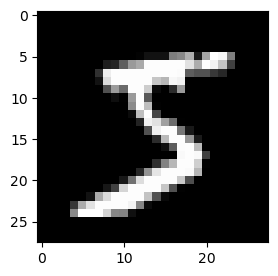

5

In [6]:
plt.figure(figsize=(3, 3))
plt.imshow(x_train[0], cmap="gray")
plt.show()
y_train[0]

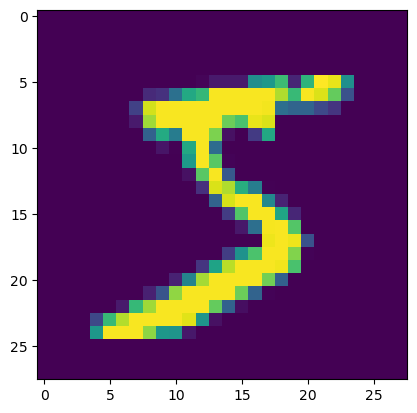

(28, 28)

In [7]:
a = x_train[0]
a.shape
plt.imshow(a)
plt.show()
a.shape

24 24 



2023-12-11 18:17:59.347952: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9804 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:68:00.0, compute capability: 7.5


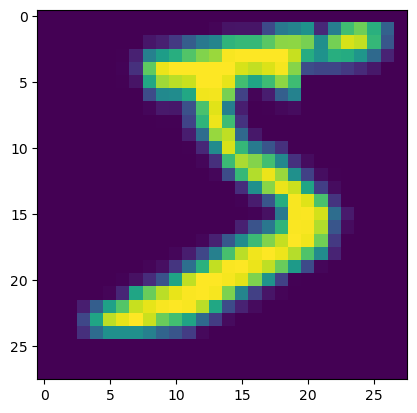

(28, 28)

In [8]:
def crop_and_resize(image):
    crop_percent = np.random.uniform(0.4, 1)

    if crop_percent == 1:
        return image
        
    # Get width and height from the image shape
    width = image.shape[0]
    height = image.shape[1]

    # Create new dimensions for the image
    crop_width = int(width * crop_percent)
    crop_height = int(height * crop_percent)
    print(crop_width, crop_height, '\n')

    cropped = tf.image.random_crop(tf.expand_dims(image, -1), (crop_width, crop_height, 1))
    cropped = tf.image.resize(cropped, (image.shape[0], image.shape[1]))
    return cropped

b = crop_and_resize(a)
b.shape
plt.imshow(b)
plt.show()
a.shape

In [9]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, x, y, batch_size=32, num_batches=100, rng: np.random.Generator = np.random.default_rng(), min_crop = .5, max_crop = 1):
        super().__init__()

        # Group by labels
        groups = [[] for _ in range(len(np.unique(y)))]
        for x_i, y_i in zip(x, y):
            groups[y_i].append(x_i)
        groups = list(map(np.array, groups))

        self.groups = groups
        self.batch_size = batch_size
        self.num_batches = num_batches
        self.rng = rng

        self.min_crop = min_crop
        self.max_crop = max_crop

        self.shuffle()

    def shuffle(self):
        self.labels = self.rng.integers(len(self.groups), size=(self.num_batches, self.batch_size))   # Which labels to draw
        self.variants = self.rng.uniform(size=(self.num_batches, 2, self.batch_size)) # Which variant of the label

    # Function to randomly crop the image
    def crop_and_resize(self, image):
        crop_percent = np.random.uniform(self.min_crop, self.max_crop)
    
        if crop_percent == 1:
            return image
            
        # Get width and height from the image shape
        width = image.shape[0]
        height = image.shape[1]
    
        # Create new dimensions for the image
        crop_width = int(width * crop_percent)
        crop_height = int(height * crop_percent)
    
        cropped = tf.image.random_crop(tf.expand_dims(image, -1), (crop_width, crop_height, 1))
        cropped = tf.squeeze(tf.image.resize(cropped, image.shape))
        
        return cropped


    def __getitem__(self, batch_index):
        batch = ([], [])
        for label, variant_a, variant_b in zip(self.labels[batch_index], *self.variants[batch_index]):
            group = self.groups[label]
            variant_a_index = int(len(group)*variant_a)
            # Instead of using two different batches, use the same with different augmentations:
            image_a = self.crop_and_resize(group[variant_a_index])
            image_b = self.crop_and_resize(group[variant_a_index])

            batch[0].append(image_a)
            batch[1].append(image_b)
            
        return tuple(np.array(batch)) # batch

    def __len__(self):
        return self.num_batches

    def on_epoch_end(self):
        self.shuffle()

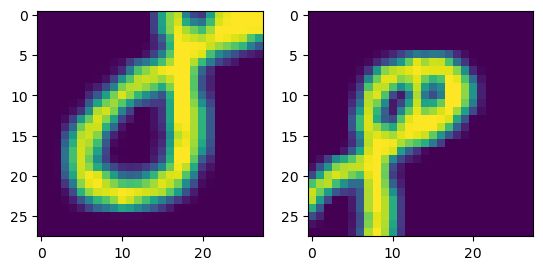

(28, 28)

In [10]:
# Generator Testing/Debugging
# [batch, x/y, set, image]
data = DataGenerator(x_train, y_train, rng=np.random.default_rng(0), min_crop = 0.4, max_crop = 1)
batch_index = 0
index = 0
plt.subplot(121)
plt.imshow(data[batch_index][0][index])
plt.subplot(122)
plt.imshow(data[batch_index][1][index])
plt.show()
data[batch_index][0][index].shape

### ViT Encoders

In [11]:
#Relative Mutli Head Attention from SirDavidLudwig's DeepDNA
#https://github.com/DLii-Research/deep-dna/tree/master

class RelativeMultiHeadAttention(keras.layers.MultiHeadAttention):
    def __init__(self, max_seq_len=None, **kwargs):
        super().__init__(**kwargs)
        self._max_seq_len = max_seq_len

    def build(self, input_shape):
        if self._max_seq_len is None:
            self._max_seq_len = input_shape[1]
            assert self._max_seq_len is not None, "RelativeMultiHeadAttention requires max_seq_len to be specified."
        self._rel_embeds = self.add_weight("relative_embeddings",
                                           shape=(self._max_seq_len, self._key_dim),
                                           initializer="glorot_uniform", trainable=True)
        return super().build(input_shape)

    def get_config(self):
        config = super().get_config()
        config.update({
            "max_seq_len": self._max_seq_len
        })
        return config

    def _skew(self, QEr):
        padded = tf.pad(QEr, [[0, 0], [0, 0], [0, 0], [1, 0]])
        shape = tf.shape(padded)
        reshaped = tf.reshape(padded, (shape[0], shape[1], shape[3], shape[2]))
        return reshaped[:,:,1:,:]

    def _compute_attention(self, query, key, value, attention_mask=None, training=None):
        # Note: Applying scalar multiply at the smaller end of einsum improves
        # XLA performance, but may introduce slight numeric differences in
        # the Transformer attention head.
        query = tf.multiply(query, 1.0 / np.sqrt(float(self._key_dim)))

        # Compute relative position encodings
        rel_enc = self._skew(tf.einsum("acbd,ed->abce", query, self._rel_embeds))

        # Take the dot product between "query" and "key" to get the raw
        # attention scores.
        attention_scores = tf.einsum(self._dot_product_equation, key, query)

        attention_scores = self._masked_softmax(attention_scores + rel_enc, attention_mask)

        # This is actually dropping out entire tokens to attend to, which might
        # seem a bit unusual, but is taken from the original Transformer paper.
        attention_scores_dropout = self._dropout_layer(attention_scores, training=training)

        # `context_layer` = [B, T, N, H]
        attention_output = tf.einsum(self._combine_equation, attention_scores_dropout, value)
        return attention_output, attention_scores


In [12]:
class TransformerBlock(keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, max_seq_len=None):
        super(TransformerBlock, self).__init__()
        self.att = RelativeMultiHeadAttention(max_seq_len=max_seq_len, num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [keras.layers.Dense(ff_dim, activation="gelu"),
             keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)

    def compute_output_shape(self, input_shape):
        return input_shape
        
    def call(self, x, training):
        y = x
        y = self.layernorm1(y, training=training)
        y, scores = self.att(y, y, return_attention_scores=True, training=training)
        y = self.dropout1(y, training=training)
        x += y
        y = x
        y = self.layernorm2(y, training=training)
        y = self.ffn(y, training=training)
        y = self.dropout2(y, training=training)
        return (x + y, scores)


In [13]:
class PositionEmbedding(keras.layers.Layer):
    def __init__(self, maxlen, embed_dim):
        super(PositionEmbedding, self).__init__()
        self.pos_emb = keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-2] # x already embedded
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        return x + positions

In [14]:
embed_dim = 64
kernel = 4
num_heads = 6
ff_dim = 512
stack = 2

# Note the input size (there is only one channel - intensity)
# these images... if you are using color images, your would
# need to set the last dimension of the input_shape to -3-
# above and this would carry over into this cell...
y = x = keras.layers.Input(shape=x_train.shape[1:])
# This layer will just be passed a constant integer for
# embedding (class token - see the ViT paper)
# input_class = keras.layers.Input(shape=(1,))

# Patches
y = keras.layers.Conv2D(embed_dim,
                        kernel_size=(kernel,kernel),
                        strides=(kernel,kernel))(tf.expand_dims(y,-1))
temp = y

# Hybrid CNN
# y = keras.layers.Conv2D(embed_dim*2,
#                         kernel_size=(5, 5),
#                         strides=2,
#                         activation='gelu')(y)
# y = keras.layers.Conv2D(embed_dim,
#                         kernel_size=(5, 5),
#                         strides=2,
#                         activation='gelu')(y)

# Flatten 2D arrangement to 1D arrangement of tokens
y = keras.layers.Reshape((-1,embed_dim))(y)
y = PositionEmbedding(y.shape[-2],embed_dim)(y)

# Create class token
c = keras.layers.Lambda(lambda x: tf.tile(tf.constant([[0]]),(tf.shape(x)[0],1)))(y)
c = keras.layers.Embedding(input_dim=1,output_dim=embed_dim)(c)

# Prepend class token
y = keras.layers.Concatenate(axis=1)([c,y])

for _ in range(stack):
    y = TransformerBlock(embed_dim, num_heads, ff_dim)(y)[0]
# Lambda layer is like the ViT the paper...
# y = keras.layers.Lambda(lambda x: x[:,0,:])(y)
# Use the following -instead- of Lambda is common in other
# models I have seen... probably not important though
y = keras.layers.GlobalAveragePooling1D()(y)
# y = keras.layers.Dropout(0.1)(y)
# y = keras.layers.Dense(embed_dim,activation='gelu')(y)
#    y = keras.layers.Dropout(0.5)(y)
# y = keras.layers.Dense(10)(y)

model = keras.Model(x,y)
# model.compile(optimizer=keras.optimizers.Nadam(learning_rate=0.0001),
#               loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=keras.metrics.SparseCategoricalAccuracy())
# model.summary()
masked_encoder = model
# model = keras.Model(x,temp)
# keras.utils.plot_model(model,show_shapes=True,expand_nested=True)

In [15]:
embed_dim = 64
kernel = 4
num_heads = 6
ff_dim = 512
stack = 2

# Note the input size (there is only one channel - intensity)
# these images... if you are using color images, your would
# need to set the last dimension of the input_shape to -3-
# above and this would carry over into this cell...
y = x = keras.layers.Input(shape=x_train.shape[1:])
# This layer will just be passed a constant integer for
# embedding (class token - see the ViT paper)
# input_class = keras.layers.Input(shape=(1,))

# Patches
y = keras.layers.Conv2D(embed_dim,
                        kernel_size=(kernel,kernel),
                        strides=(kernel,kernel))(tf.expand_dims(y,-1))
# Hybrid CNN
# y = keras.layers.Conv2D(embed_dim*2,
#                         kernel_size=(5, 5),
#                         strides=2,
#                         activation='gelu')(y)
# y = keras.layers.Conv2D(embed_dim,
#                         kernel_size=(5, 5),
#                         strides=2,
#                         activation='gelu')(y)

# Flatten 2D arrangement to 1D arrangement of tokens
y = keras.layers.Reshape((-1,embed_dim))(y)
y = PositionEmbedding(y.shape[-2],embed_dim)(y)

# Create class token
c = keras.layers.Lambda(lambda x: tf.tile(tf.constant([[0]]),(tf.shape(x)[0],1)))(y)
c = keras.layers.Embedding(input_dim=1,output_dim=embed_dim)(c)

# Prepend class token
y = keras.layers.Concatenate(axis=1)([c,y])

for _ in range(stack):
    y = TransformerBlock(embed_dim, num_heads, ff_dim)(y)[0]
# Lambda layer is like the ViT the paper...
# y = keras.layers.Lambda(lambda x: x[:,0,:])(y)
# Use the following -instead- of Lambda is common in other
# models I have seen... probably not important though
y = keras.layers.GlobalAveragePooling1D()(y)
# y = keras.layers.Dropout(0.1)(y)
# y = keras.layers.Dense(embed_dim,activation='gelu')(y)
#    y = keras.layers.Dropout(0.5)(y)
# y = keras.layers.Dense(10)(y)

model = keras.Model(x,y)
# model.compile(optimizer=keras.optimizers.Nadam(learning_rate=0.0001),
#               loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=keras.metrics.SparseCategoricalAccuracy())
model.summary()
unmasked_encoder = model
# keras.utils.plot_model(model,show_shapes=True,expand_nested=True)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28)]     0           []                               
                                                                                                  
 tf.expand_dims_1 (TFOpLambda)  (None, 28, 28, 1)    0           ['input_2[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 64)     1088        ['tf.expand_dims_1[0][0]']       
                                                                                                  
 reshape_1 (Reshape)            (None, 49, 64)       0           ['conv2d_1[0][0]']               
                                                                                            

### Note: This metric only *correlates* with accuracy

This is an approximate accuracy which doesn't really track the model's actual performance, and is just used here as a metric to show progress.

In [16]:
accuracy = keras.metrics.SparseCategoricalAccuracy()
def ContrastiveAccuracy(y_true, y_pred):
    # return accuracy(y_true[tf.argmax(y_pred,-1)],
    #                 y_pred)
    acc_masked = accuracy(y_true, y_pred)
    acc_unmasked = accuracy(y_true, tf.transpose(y_pred))
    acc = (acc_masked + acc_unmasked) / 2.0
    return acc

In [17]:
class ContrastiveModel(tf.keras.Model):
    def __init__(
        self,
        masked_encoder: tf.keras.Model,
        unmasked_encoder: tf.keras.Model,
        embed_dim: int = 512,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.masked_encoder = masked_encoder
        self.unmasked_encoder = unmasked_encoder

#         self.masked_encoder.trainable = False
#         self.unmasked_encoder.trainable = False

        self.embed_dim = embed_dim
        self.W_masked = tf.keras.layers.Dense(
            self.embed_dim,
            # input_shape=self.masked_encoder.output_shape[-1],
            use_bias=False)
        self.W_unmasked = tf.keras.layers.Dense(
            self.embed_dim,
            # input_shape=self.unmasked_encoder.output_shape[-1],
            use_bias=False)
        self.t = self.add_weight(
            name="Temperature",
            shape=None,
            trainable=True
        )

    def compile(self, *args, **kwargs):
        return super().compile(
            *args,
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            **kwargs)

    def test_step(self, data):
        n = tf.shape(data[0])[0]
        y_true = tf.range(n)
        y_pred = self(data, training=False)
        loss_masked = self.compiled_loss(y_true, y_pred)
        loss_unmasked = self.compiled_loss(y_true, tf.transpose(y_pred))
        loss = (loss_masked + loss_unmasked) / 2.0
        self.compiled_metrics.update_state(y_true, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def train_step(self, data):
        n = tf.shape(data[0])[0]
        y_true = tf.range(n)
        with tf.GradientTape() as tape:
            y_pred = self(data, training=True)
            loss_masked = self.compiled_loss(y_true, y_pred)
            loss_unmasked = self.compiled_loss(y_true, tf.transpose(y_pred))
            loss = (loss_masked + loss_unmasked) / 2.0
        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.compiled_metrics.update_state(y_true, y_pred)
        return {m.name: m.result() for m in self.metrics}

    def call(self, inputs, training=False):
        # Get the images from input
        masked_images, unmasked_images = inputs[0], inputs[1]

        # Embed them using the encoders
        masked_features = self.masked_encoder(masked_images)
        unmasked_features = self.unmasked_encoder(unmasked_images)

        # Joint multimodal embedding
        masked_embeddings = self.W_masked(masked_features)
        unmasked_embeddings = self.W_unmasked(unmasked_features)

        # Normalize
        masked_embeddings = masked_embeddings / tf.norm(masked_embeddings)
        unmasked_embeddings = unmasked_embeddings / tf.norm(unmasked_embeddings)

        logits = tf.tensordot(masked_embeddings, tf.transpose(unmasked_embeddings), axes=1) * tf.exp(self.t)

        return logits

In [18]:
cm = ContrastiveModel(masked_encoder, unmasked_encoder)
cm.compile(
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[
        ContrastiveAccuracy
    ],
    run_eagerly=False # Set to true to debug
)

In [19]:
data[0][1][:4].shape

(4, 28, 28)

In [20]:
cm((data[0][0][:4],data[0][1][:4]))

2023-12-11 18:18:01.213964: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8800


<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[-0.00832582, -0.00785728, -0.00640082, -0.01011904],
       [-0.00458156, -0.00336003, -0.00273784, -0.00630155],
       [-0.00623451, -0.00656486, -0.00542668, -0.00913957],
       [-0.00815359, -0.00788638, -0.00676085, -0.0105783 ]],
      dtype=float32)>

In [21]:
training_data = DataGenerator(x_train, y_train, batch_size=32, rng=np.random.default_rng(0), min_crop = 0.4, max_crop = 1)
# No cropping
validation_data = DataGenerator(x_val, y_val, batch_size=32, rng=np.random.default_rng(0), min_crop = 1, max_crop = 1)

In [22]:
len(training_data[0][0])

32

In [23]:
cm(validation_data[0])

<tf.Tensor: shape=(32, 32), dtype=float32, numpy=
array([[-9.31109127e-04, -5.88802097e-04, -1.16842764e-03, ...,
        -9.61535377e-04, -1.43894786e-03, -1.39971741e-03],
       [-8.02952971e-04, -4.36416740e-04, -9.38789512e-04, ...,
        -7.45000143e-04, -1.19403412e-03, -1.19864906e-03],
       [-7.25947670e-04, -2.89749354e-04, -8.51300429e-04, ...,
        -6.45881228e-04, -1.08295667e-03, -9.08498769e-04],
       ...,
       [-6.95080962e-04, -2.43185030e-04, -8.55666120e-04, ...,
        -5.64623624e-04, -1.05300616e-03, -9.63798957e-04],
       [-5.51610428e-04, -1.13448295e-04, -7.25477817e-04, ...,
        -4.41897399e-04, -9.32432420e-04, -9.46076994e-04],
       [-1.28518790e-04,  3.51093564e-04, -1.85409968e-04, ...,
        -3.38494510e-06, -2.85431684e-04, -3.59747704e-04]], dtype=float32)>

In [24]:
ContrastiveAccuracy(np.arange(validation_data[0][0].shape[0]),cm(validation_data[0]))

<tf.Tensor: shape=(), dtype=float32, numpy=0.03125>

In [25]:
callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", mode = 'min', patience = 15)
history = cm.fit(training_data,
                 epochs=300,
                 verbose=1,
                 validation_data=validation_data,
                 callbacks=[callback]
                )

Epoch 1/300


2023-12-11 18:18:02.569323: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-12-11 18:18:09.961724: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x55af9c565430 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-11 18:18:09.961963: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-12-11 18:18:10.047242: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-11 18:18:10.501444: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most on

100/100 [==============================] - ETA: 0s - loss: 3.4587 - ContrastiveAccuracy: 0.0502

2023-12-11 18:18:25.673985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


100/100 [==============================] - 24s 111ms/step - loss: 3.4587 - ContrastiveAccuracy: 0.0502 - val_loss: 3.4584 - val_ContrastiveAccuracy: 0.0555
Epoch 2/300
100/100 [==============================] - 10s 103ms/step - loss: 3.4553 - ContrastiveAccuracy: 0.0573 - val_loss: 3.4585 - val_ContrastiveAccuracy: 0.0577
Epoch 3/300
100/100 [==============================] - 10s 103ms/step - loss: 3.4542 - ContrastiveAccuracy: 0.0579 - val_loss: 3.4506 - val_ContrastiveAccuracy: 0.0580
Epoch 4/300
100/100 [==============================] - 10s 103ms/step - loss: 3.4520 - ContrastiveAccuracy: 0.0581 - val_loss: 3.4519 - val_ContrastiveAccuracy: 0.0582
Epoch 5/300
100/100 [==============================] - 10s 103ms/step - loss: 3.4495 - ContrastiveAccuracy: 0.0584 - val_loss: 3.4453 - val_ContrastiveAccuracy: 0.0586
Epoch 6/300
100/100 [==============================] - 10s 102ms/step - loss: 3.4453 - ContrastiveAccuracy: 0.0588 - val_loss: 3.4355 - val_ContrastiveAccuracy: 0.0590
Epoc

In [26]:
cm.summary()

Model: "contrastive_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 64)                342464    
                                                                 
 model_1 (Functional)        (None, 64)                342464    
                                                                 
 dense_8 (Dense)             multiple                  32768     
                                                                 
 dense_9 (Dense)             multiple                  32768     
                                                                 
Total params: 750,465
Trainable params: 750,465
Non-trainable params: 0
_________________________________________________________________


In [27]:
with open("training_history.txt", 'w') as file:
    file.write(f"Epochs: {len(history.history['loss'])}\n")
    file.write(f"Loss: {history.history['loss'][-1]}\n")
    file.write(f"Validation Loss: {history.history['val_loss'][-1]}\n")
    file.write(f"Contrastive Accuracy: {history.history['ContrastiveAccuracy'][-1] * 100}%\n")
    file.write(f"Validation Contrastive Accuracy: {history.history['val_ContrastiveAccuracy'][-1] * 100}%\n")

In [39]:
cm.save_weights("Weights/ViT-Relative-12-1-23")

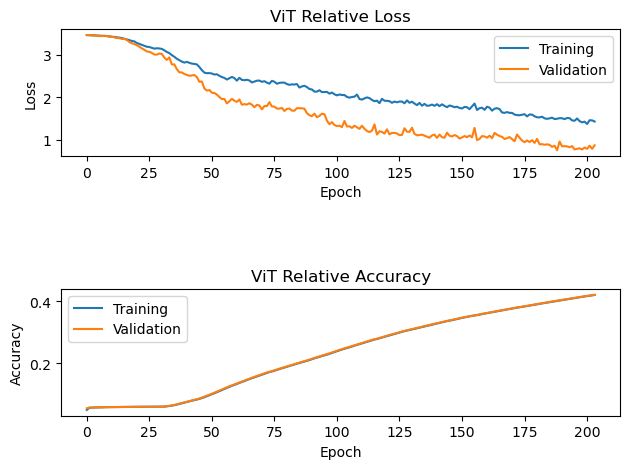

In [40]:
# Plot History in one image
plt.figure(1)

# Loss history
plt.subplot(211)
plt.plot(history.history['loss'],label='Training')
plt.plot(history.history['val_loss'],label='Validation')
plt.legend()

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ViT Relative Loss')

# Accuracy history
plt.subplot(212)
plt.plot(history.history['ContrastiveAccuracy'],label='Training')
plt.plot(history.history['val_ContrastiveAccuracy'],label='Validation')
plt.legend()

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('ViT Relative Accuracy')

plt.tight_layout(h_pad = 5.0)
plt.savefig('history.png')
plt.show()

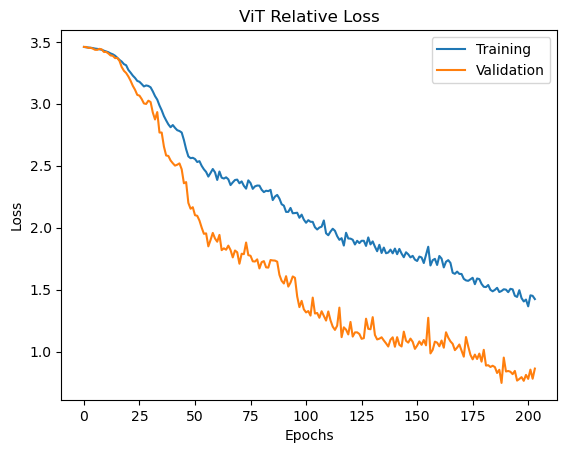

In [41]:
# Plot Loss in individual image
plt.plot(history.history['loss'],label='Training')
plt.plot(history.history['val_loss'],label='Validation')
plt.legend()

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('ViT Relative Loss')

plt.savefig('history_loss.png')
plt.show()

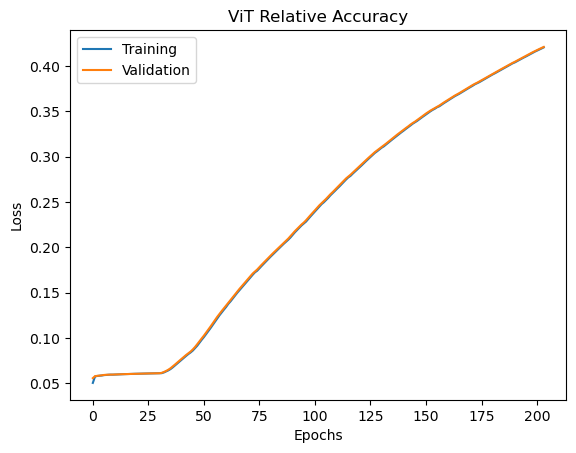

In [42]:
# Plot Accuracy in individual image
plt.plot(history.history['ContrastiveAccuracy'],label='Training')
plt.plot(history.history['val_ContrastiveAccuracy'],label='Validation')
plt.legend()

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('ViT Relative Accuracy')

plt.savefig('history_acc.png')
plt.show()

### Obtaining Realistic Accuracies

In [43]:
offset = 0
n_comp = 100

In [44]:
# update with notes to compare
cm((x_val[0:1],x_train[offset:offset+n_comp]))

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[-72.235664 ,  -3.8605049, -26.399536 ,   6.305437 ,  -1.5451634,
        -25.34533  , -82.74507  , -40.16518  , -51.189674 ,  14.695642 ,
        -55.04699  ,  -8.746872 , -56.234688 ,  12.846314 , -49.303772 ,
         10.878586 , -43.684856 , -12.335782 ,  -9.782861 ,   5.889885 ,
        -75.033    , -21.774687 ,  16.682577 ,   7.9315042, -34.52922  ,
        -37.733307 , -19.580416 , -59.344944 , -48.28281  ,  10.623447 ,
        -45.83359  , -20.528986 ,   8.14895  ,   7.2513843, -16.265873 ,
         -1.1997019, -37.993305 , -27.030937 , -28.460114 ,  -8.008462 ,
        -39.384964 , -13.621149 , -13.852325 ,  14.587149 ,   3.7096217,
         10.408582 , -29.91952  , -59.880695 , -62.648216 , -63.74081  ,
        -37.729343 , -27.515087 ,   7.4708447,  13.858329 ,   6.0352254,
         -9.342829 , -63.249332 ,  15.706642 , -57.23625  ,   1.8508859,
        -19.138117 ,  16.178797 , -23.307915 , -33.17758  ,  11.493704 ,
 

In [45]:
y_val[0:1]

array([7], dtype=uint8)

In [46]:
y_train[np.argmax(cm((x_val[0:1],x_train[offset:offset+n_comp])))+offset]

9

In [47]:
accuracy = 0.0
n = 10
with open("10_accuracy.txt", 'w') as file:
    print("True\tPred")
    file.write("True\tPred" + '\n')
    for i in range(n):
        true = y_val[i] 
        pred = y_train[np.argmax(cm((x_val[i:i+1], x_train[offset:offset+n_comp])))+offset]
        print(true, '\t', pred, end = '')
        file.write(str(true) + '\t\t' + str(pred))
        if (y_val[i] == y_train[np.argmax(cm((x_val[i:i+1], x_train[offset:offset+n_comp])))+offset]):
            accuracy+= 1.0
            print("\t\u2714\n")
            file.write("\t\t\u2714\n")
        else:
            print('\n')
            file.write('\n')

    accuracy /= n
    print(f"Accuracy: {accuracy*100}%")
    file.write(f"Accuracy: {accuracy*100}%\n")

True	Pred
7 	 9

2 	 6

1 	 1	✔

0 	 0	✔

4 	 4	✔

1 	 1	✔

4 	 9

9 	 3

5 	 3

9 	 9	✔

Accuracy: 50.0%


In [48]:
accuracy = 0.0
n = y_val.shape[0]
print(n, "computations to make . . .")
for i in range(n):
   # print(y_val[i:i+1],end='\t')
    #print(y_train[np.argmax(cm((x_val[i:i+1], x_train[offset:offset+n_comp])))+offset])
    if (i % (n / 10) == 0 or i == n - 1):
        print(f"\rProgress: {i}/{n} ({(i/n)*100:.2f}%)", end="")  # Update the progress
    if (y_val[i] == y_train[np.argmax(cm((x_val[i:i+1], x_train[offset:offset+n_comp])))+offset]):
        accuracy+= 1.0

accuracy /= n
print(f"\nFinal Accuracy: {accuracy*100}%")
with open("final_accuracy.txt", 'w') as file:
    file.write(f"Final Accuracy: {accuracy*100}%\n")

10000 computations to make . . .
Progress: 9999/10000 (99.99%)
Final Accuracy: 30.630000000000003%
